이슈 추가할것
* 학습시킬 데이터의 column 확장 (forecast + obs)
  - forecast data는 보간 필요할듯
  - time을 base로 하고, 시간이 일치하는 row를 끼워넣는 방식
* 내 코드 공유코드로 적용해서 옮기기.
  - 셀 추가한뒤 comment 달기
  - 이슈 변경 및 추가하기

# 예보 데이터 불러오기
[인증키 확인](https://data.go.kr/iim/api/selectAPIAcountView.do)

In [1]:
! pip install xmltodict

In [1]:
import pandas as pd
from urllib.parse import urlencode, quote_plus
from urllib.request import urlopen
import json
import xmltodict

In [2]:
# API
ServiceKey = input('openweathermap에서 복사한 api key를 입력해주세요 > '


In [4]:
def get_forecast(fcst_date, ServiceKey, x: int, y: int):
    '''
    해당 x, y좌표의 예보 받아오기
    e.g. fcst_date = "2021-04-21"
    '''
    url_base = 'http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst'
    key = ServiceKey
    queryParams = urlencode({
        # quote_plus('ServiceKey'): key,
        quote_plus('numOfRows'): '113',
        quote_plus('dataType'): 'JSON',
        quote_plus('base_date'): '20210528',
        quote_plus('base_time'): '1400',
        quote_plus('nx'): str(x),
        quote_plus('ny'): str(y),
    })

    url = f'{url_base}?serviceKey={key}&{queryParams}'
    response = urlopen(url)
    res_json = json.loads(response)

    df = pd.DataFrame()
    df['Forecast_time'] = [f'{fcst_date} {hour}:00' for hour in range(24)]
    row_idx = 0

    for i, data in enumerate(res_json['response']['body']['items']['item']):
        if i > 19:
            if data['category']=='REH':
                df.loc[row_idx, 'Humidity'] = float(data['fcstValue'])
                print('category:Humidity,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
            elif data['category']=='T3H':
                df.loc[row_idx, 'Temperature'] = float(data['fcstValue'])
                print('category:Temperature,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
            elif data['category']=='SKY':
                df.loc[row_idx, 'Cloud'] = float(data['fcstValue'])
                print('category:Cloud,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
            elif data['category']=='VEC':
                df.loc[row_idx, 'WindDirection'] = float(data['fcstValue'])
                print('category:WindDirection,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
            elif data['category']=='WSD':
                df.loc[row_idx, 'WindSpeed'] = float(data['fcstValue'])
                print('category:WindSpeed,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'], '\n')
                row_idx+=3
    df = df.interpolate()
    df = df.iloc[:24]

    return df


In [15]:

fcst_date = '2021-05-30'
x = 102
y = 83


# url_base = 'http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst'
url_base = 'http://apis.data.go.kr/1360000/VilageFcstInfoService/getUltraSrtFcst'
key = ServiceKey
queryParams = urlencode({
    # quote_plus('ServiceKey'): key,
    quote_plus('numOfRows'): '113',
    quote_plus('dataType'): 'XML',
    quote_plus('base_date'): '20210229',
    quote_plus('base_time'): '2300',
    quote_plus('nx'): str(x),
    quote_plus('ny'): str(y),
})

url = f'{url_base}?serviceKey={key}&{queryParams}'
response = urlopen(url)
results = response.read().decode('utf-8')
results_json = xmltodict.parse(results)

data = json.loads(json.dumps(results_json))

if 'ERROR' in data['response']['header']['resultMsg']:
    print('Fail.')
else:
    print('Success!')
  

Success!


In [16]:
data

{'response': {'header': {'resultCode': '99',
   'resultMsg': '최근 1일 간의 자료만 제공합니다.'}}}

In [23]:
logs = data['response']['body']['items']['item']
df = pd.DataFrame()

for log in logs:
    s_tmp = pd.Series(log)
    df_tmp = pd.DataFrame(s_tmp)
    df = pd.concat([df, df_tmp.T])

def fcst_time(time):
    temp = f'{time[:4]}-{time[4:6]}-{time[6:8]} {time[9:11]}:{time[11:]}'
    datetime = pd.to_datetime(temp)
    return datetime

df['time'] = df[['fcstDate', 'fcstTime']].apply(lambda t: ' '.join(t), axis=1)
df['time'] = df['time'].apply(fcst_time)

fcst_df = pd.DataFrame(columns=['time', 'fcst_temp', 'fcst_hum', 'fcst_wspeed',
                                'fcst_wdirect', 'fcst_cloud'])


In [25]:
df

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny,time
0,20210529,2300,POP,20210530,0300,10,102,83,2021-05-30 03:00:00
0,20210529,2300,PTY,20210530,0300,0,102,83,2021-05-30 03:00:00
0,20210529,2300,REH,20210530,0300,75,102,83,2021-05-30 03:00:00
0,20210529,2300,SKY,20210530,0300,1,102,83,2021-05-30 03:00:00
0,20210529,2300,T3H,20210530,0300,17,102,83,2021-05-30 03:00:00
...,...,...,...,...,...,...,...,...,...
0,20210529,2300,UUU,20210531,0900,1.4,102,83,2021-05-31 09:00:00
0,20210529,2300,VEC,20210531,0900,211,102,83,2021-05-31 09:00:00
0,20210529,2300,VVV,20210531,0900,2.3,102,83,2021-05-31 09:00:00
0,20210529,2300,WSD,20210531,0900,2.7,102,83,2021-05-31 09:00:00


In [29]:
a = pd.to_datetime('20210529 230102')
a

Timestamp('2021-05-29 23:01:02')

In [ ]:
df[(df['fcstDate']=='20210528') & (df['fcstTime']=='2100')]

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
0,20210528,1400,POP,20210528,2100,0,102,83
0,20210528,1400,PTY,20210528,2100,0,102,83
0,20210528,1400,REH,20210528,2100,70,102,83
0,20210528,1400,SKY,20210528,2100,1,102,83
0,20210528,1400,T3H,20210528,2100,19,102,83
0,20210528,1400,UUU,20210528,2100,2.9,102,83
0,20210528,1400,VEC,20210528,2100,237,102,83
0,20210528,1400,VVV,20210528,2100,1.9,102,83
0,20210528,1400,WSD,20210528,2100,3.5,102,83


In [ ]:
data

{'response': {'body': {'dataType': 'XML',
   'items': {'item': [{'baseDate': '20210528',
      'baseTime': '1400',
      'category': 'POP',
      'fcstDate': '20210528',
      'fcstTime': '1800',
      'fcstValue': '60',
      'nx': '102',
      'ny': '83'},
     {'baseDate': '20210528',
      'baseTime': '1400',
      'category': 'PTY',
      'fcstDate': '20210528',
      'fcstTime': '1800',
      'fcstValue': '1',
      'nx': '102',
      'ny': '83'},
     {'baseDate': '20210528',
      'baseTime': '1400',
      'category': 'R06',
      'fcstDate': '20210528',
      'fcstTime': '1800',
      'fcstValue': '2',
      'nx': '102',
      'ny': '83'},
     {'baseDate': '20210528',
      'baseTime': '1400',
      'category': 'REH',
      'fcstDate': '20210528',
      'fcstTime': '1800',
      'fcstValue': '80',
      'nx': '102',
      'ny': '83'},
     {'baseDate': '20210528',
      'baseTime': '1400',
      'category': 'S06',
      'fcstDate': '20210528',
      'fcstTime': '1800',
      

In [ ]:


df = pd.DataFrame()
df['Forecast_time'] = [f'{fcst_date} {hour}:00' for hour in range(24)]
row_idx = 0

for i, data in enumerate(res_json['response']['body']['items']['item']):
    if i > 19:
        if data['category']=='REH':
            df.loc[row_idx, 'Humidity'] = float(data['fcstValue'])
            print('category:Humidity,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        elif data['category']=='T3H':
            df.loc[row_idx, 'Temperature'] = float(data['fcstValue'])
            print('category:Temperature,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        elif data['category']=='SKY':
            df.loc[row_idx, 'Cloud'] = float(data['fcstValue'])
            print('category:Cloud,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        elif data['category']=='VEC':
            df.loc[row_idx, 'WindDirection'] = float(data['fcstValue'])
            print('category:WindDirection,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        elif data['category']=='WSD':
            df.loc[row_idx, 'WindSpeed'] = float(data['fcstValue'])
            print('category:WindSpeed,',data['category'], 'baseTime:',data['baseTime'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'], '\n')
            row_idx+=3
df = df.interpolate()
df = df.iloc[:24]

return df

AttributeError: ignored

In [ ]:
fcst_ulsan = get_forecast('2021-05-29', ServiceKey, 102, 83)

TypeError: ignored

# Install packages and Download files

In [ ]:
# Install packages
! pip install pytorch-forecasting
! pip install pytorch-lightning

# Download Files
! mkdir dataset
! wget -NP ./dataset https://raw.githubusercontent.com/LeeSH825/TemporalFusionTransformer/master/csv_data/dangjin_obs_data.csv
! wget -NP  ./dataset https://raw.githubusercontent.com/LeeSH825/TemporalFusionTransformer/master/csv_data/dangjin_fcst_data.csv
! wget -NP ./dataset https://raw.githubusercontent.com/LeeSH825/TemporalFusionTransformer/master/csv_data/ulsan_obs_data.csv
! wget -NP  ./dataset https://raw.githubusercontent.com/LeeSH825/TemporalFusionTransformer/master/csv_data/ulsan_fcst_data.csv
! wget -NP  ./dataset https://raw.githubusercontent.com/LeeSH825/TemporalFusionTransformer/master/csv_data/energy.csv

     |████████████████████████████████| 112kB 9.1MB/s 
     |████████████████████████████████| 296kB 35.0MB/s 
     |████████████████████████████████| 808kB 35.6MB/s 
     |████████████████████████████████| 22.3MB 68.6MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 174kB 48.0MB/s 
     |████████████████████████████████| 829kB 33.8MB/s 
     |████████████████████████████████| 112kB 53.1MB/s 
     |████████████████████████████████| 10.6MB 13.5MB/s 
     |████████████████████████████████| 645kB 45.2MB/s 
     |████████████████████████████████| 276kB 51.6MB/s 
     |████████████████████████████████| 143kB 58.8MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 112kB 51.0MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
     |████████████████████████████████| 1.3MB 39.3MB/s 
     |████████████████████████████████| 143kB 58.2MB/s 
     |████████████████████████████████| 296kB 53.1M

In [ ]:
# import
import os
import warnings

import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
pd.set_option('max_rows', 15)
pd.set_option('max_columns', 15)

print("import Done!")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



import Done!


# test code

In [ ]:
# start and end time of data
time_start = pd.to_datetime('2018-04-01 00:00:00')
time_end = pd.to_datetime('2021-01-31 23:00:00')

# how many time tags
time_len = int((time_end - time_start) / pd.Timedelta(hours=1)) + 1

# Make base dataframe
delta = pd.to_timedelta(np.arange(time_len), unit='h')
time_base = time_start + delta

# set base
data_base = pd.DataFrame()
data_base['time'] = time_base
data_base['idx'] = data_base.index

data_base['month'] = data_base['time'].dt.month_name() # string
data_base['week_of_year'] = data_base['time'].dt.week
data_base['day_of_month'] = data_base['time'].dt.day.apply(str)
data_base['hour_of_day'] = data_base['time'].dt.hour.apply(str)

# --------------------
print(f'Data starts from [ {time_start} ] to [ {time_end} ].')
print(f'Total length : {time_len}')


Data starts from [ 2018-04-01 00:00:00 ] to [ 2021-01-31 23:00:00 ].
Total length : 24888


In [ ]:
def convert2400(time_str):
  '''
  convert type of time data, string -> datetime
  e.g. < string "2020-01-01 24:00:00" > to < datetime "2020-01-02 00:00:00" >
  '''
  if "24:00:00" in time_str:
    tmp = time_str.replace("24:00:00", "00:00:00")
    tmp = pd.to_datetime(tmp)
    tmp = tmp + pd.Timedelta(days=1)
  else:
    tmp = pd.to_datetime(time_str)
  return tmp

def get_fcst_data(region, data_path):
  '''
  get fcst data.
  '''
  # load csv file
  df_fcst = pd.read_csv(f'{data_path}/{region}_fcst_data.csv')

  # create empty dataframe
  data_fcst = pd.DataFrame(columns=['time', 'fcst_temp', 'fcst_hum',
                                    'fcst_wspeed', 'fcst_wdirect', 'fcst_cloud'])
  
  # time preprocess
  forecast_time = df_fcst['Forecast time'].apply(convert2400)
  forecast = df_fcst['forecast'].astype('int')
  forecast = forecast.apply(lambda h: pd.Timedelta(hours=h))
  
  # wind_direction simplification
  bin_boundary = list(range(0, 361, 45))
  bin_names = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']
  wd = pd.cut(df_fcst['WindDirection'],
              bins=bin_boundary,
              labels=bin_names,
              include_lowest=True)
  
  # fill dataframe
  data_fcst['time'] = forecast_time + forecast
  data_fcst['fcst_temp'] = df_fcst['Temperature']
  data_fcst['fcst_hum'] = df_fcst['Humidity']
  data_fcst['fcst_wspeed'] = df_fcst['WindSpeed']
  data_fcst['fcst_cloud'] = df_fcst['Cloud']
  data_fcst['fcst_wdirect'] = wd

  return data_fcst


def get_obs_data(region, data_path):
  '''
  get fcst data.
  '''
  # load csv file
  df_obs = pd.read_csv(f'{data_path}/{region}_obs_data.csv')

  # create empty dataframe
  data_obs = pd.DataFrame(columns=['time', 'id', 'region', 'obs_temp',
                                   'obs_hum', 'obs_wspeed', 'obs_wdirect',
                                   'obs_cloud'])

  # wind_direction simplification
  bin_boundary = list(range(0, 361, 45))
  bin_names = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']
  wd = pd.cut(df_obs['풍향(16방위)'],
              bins=bin_boundary,
              labels=bin_names,
              include_lowest=True)
  
  # dictionary for convert korean -> english
  dict_region = {'울산': 'Ulsan', '서산': 'Seosan'}

  # fill dataframe
  data_obs['time'] = df_obs['일시'].apply(convert2400)
  data_obs['id'] = df_obs['지점'].apply(str)
  data_obs['region'] = df_obs['지점명'].apply(lambda x: dict_region[x])
  data_obs['obs_temp'] = df_obs['기온(°C)']
  data_obs['obs_wspeed'] = df_obs['풍속(m/s)']
  data_obs['obs_wdirect'] = wd
  data_obs['obs_hum'] = df_obs['습도(%)']
  data_obs['obs_cloud'] = df_obs['전운량(10분위)']

  return data_obs


def get_energy_data(plant, data_path):
  '''
  get energy data.
  '''
  # load csv file
  df_energy = pd.read_csv(f'{data_path}/energy.csv')

  # create empty dataframe
  data_energy = pd.DataFrame(columns=['time', 'energy'])

  # fill dataframe
  data_energy['time'] = df_energy['time'].apply(convert2400) - pd.Timedelta(hours=1)
  data_energy['energy'] = df_energy['ulsan']

  return data_energy


In [ ]:
# Default Params
data_path = './dataset'
region_default = {'dangjin_floating': 'dangjin',
                  'dangjin_warehouse': 'dangjin',
                  'dangjin': 'dangjin',
                  'ulsan': 'ulsan'} # plant, region

data = pd.DataFrame()
for plant, region in region_default.items():
  # 해당 발전소의 data를 불러옴
  data_fcst = get_fcst_data(region, data_path)
  data_obs = get_obs_data(region, data_path)
  data_energy = get_energy_data(plant, data_path)

  # 하나의 dataframe으로 합침
  data_region = pd.merge(data_base, data_fcst, how='left', on='time')
  data_region = pd.merge(data_region, data_obs, how='left', on='time')
  data_region = pd.merge(data_region, data_energy, how='left', on='time')

  # data에 합치기
  data = pd.concat([data, data_region])



In [ ]:
data.head()

,time,idx,month,week_of_year,day_of_month,hour_of_day,fcst_temp,...,region,obs_temp,obs_hum,obs_wspeed,obs_wdirect,obs_cloud,energy
0,2018-04-01,0,April,13,1,0,9.0,...,Seosan,9.0,68.0,0.7,SSE,NaN,0
1,2018-04-01,0,April,13,1,0,9.0,...,Seosan,9.0,68.0,0.7,SSE,NaN,0
2,2018-04-01,0,April,13,1,0,9.0,...,Seosan,9.0,68.0,0.7,SSE,NaN,0
3,2018-04-01,0,April,13,1,0,9.0,...,Seosan,9.0,68.0,0.7,SSE,NaN,0
4,2018-04-01,0,April,13,1,0,9.0,...,Seosan,9.0,68.0,0.7,SSE,NaN,0


# Preprocessing 1

In [ ]:
# Ready for preprocess
! mkdir data

# ------------------------------------- class --
class Path():
  def __init__(self):
    self.path_dataset = './dataset'
    self.path_data = './data'
    self.path_data = self.get_data_path('dacon_data.csv')

    self.split_size = (0.99, 0.00, 0.01)
    self.x = None
    self.y = None
    self.df = None

  def get_dataset_path(self, name_data):
    """
    get data path in dataset directory
    """
    path = os.path.join(self.path_dataset, name_data)
    return path

  def get_data_path(self, name_data):
    """
    get data path in data directory
    """
    path = os.path.join(self.path_data, name_data)
    return path
# ----------------------------------------------


path = Path()


In [ ]:
# Select region for train

# selected_region = 'ulsan'
selected_region = 'dangjin'

In [ ]:
file_name_fcst = f'{selected_region}_fcst_data.csv'
file_name_obs = f'{selected_region}_obs_data.csv'
file_name_energy = 'energy.csv'

df_fcst = pd.read_csv(path.get_dataset_path(file_name_fcst))
df_obs = pd.read_csv(path.get_dataset_path(file_name_obs))
df_energy = pd.read_csv(path.get_dataset_path(file_name_energy))

# fcst data는 사용하지 않았음.

In [ ]:
print(df_fcst.head(3))
print()
print(df_obs.head(3))
print()
print(df_energy.head(3))
print()

         Forecast time  forecast  Temperature  Humidity  WindSpeed  \
0  2018-03-01 11:00:00       4.0          0.0      60.0        7.3   
1  2018-03-01 11:00:00       7.0         -2.0      60.0        7.1   
2  2018-03-01 11:00:00      10.0         -2.0      60.0        6.7   

   WindDirection  Cloud  
0          309.0    2.0  
1          314.0    1.0  
2          323.0    1.0  

    지점 지점명                일시  기온(°C)  풍속(m/s)  풍향(16방위)  습도(%)  전운량(10분위)
0  129  서산  2018-03-01 00:00     3.1      3.6     340.0   96.0        NaN
1  129  서산  2018-03-01 01:00     2.8      0.7     140.0   97.0        NaN
2  129  서산  2018-03-01 02:00     2.6      3.2     320.0   95.0        NaN

                 time  dangjin_floating  dangjin_warehouse  dangjin  ulsan
0  2018-03-01 1:00:00               0.0                0.0        0      0
1  2018-03-01 2:00:00               0.0                0.0        0      0
2  2018-03-01 3:00:00               0.0                0.0        0      0



In [ ]:
df_obs['지점명'].value_counts()

서산    25626
Name: 지점명, dtype: int64

* Make base time data

In [ ]:
# start and end time of data
time_start = pd.to_datetime('2018-04-01 00:00:00')
time_end = pd.to_datetime('2021-01-31 23:00:00')

# how many time tags
time_len = int((time_end - time_start) / pd.Timedelta(hours=1)) + 1

# Make base dataframe
delta = pd.to_timedelta(np.arange(time_len), unit='h')
time_base = time_start + delta

# --------------------
print(f'Data starts from [ {time_start} ] to [ {time_end} ].')
print(f'Total length : {time_len}')


Data starts from [ 2018-04-01 00:00:00 ] to [ 2021-01-31 23:00:00 ].
Total length : 24888


* function : Convert data ( string -> datetime )

In [ ]:
# convert < string "2020-01-01 24:00:00" > to < datetime "2020-01-02 00:00:00" >
def convert2400(time_str):
  if "24:00:00" in time_str:
    tmp = time_str.replace("24:00:00", "00:00:00")
    tmp = pd.to_datetime(tmp)
    tmp = tmp + pd.Timedelta(days=1)
  else:
    tmp = pd.to_datetime(time_str)
  return tmp

* Preprocess Forecast dataset

In [ ]:
# Ulsan
if selected_region == 'ulsan':
  data_fcst = pd.DataFrame(columns=['time', 'temperature', 'humidity',
                                    'wind_speed', 'wind_direction', 'cloud'])
  # time setting
  forecast_time = df_fcst['Forecast time'].apply(convert2400)
  forecast = df_fcst['forecast'].astype('int')
  forecast = forecast.apply(lambda h: pd.Timedelta(hours=h))
  
  # wind_direction simplification
  bin_boundary = list(range(0, 361, 45))
  bin_names = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']
  wd = pd.cut(df_fcst['WindDirection'],
              bins=bin_boundary,
              labels=bin_names,
              include_lowest=True)
  
  data_fcst['time'] = forecast_time + forecast
  data_fcst['temperature'] = df_fcst['Temperature']
  data_fcst['humidity'] = df_fcst['Humidity']
  data_fcst['wind_speed'] = df_fcst['WindSpeed']
  data_fcst['cloud'] = df_fcst['Cloud']
  data_fcst['wind_direction'] = wd

# Dangjin
elif selected_region == 'dangjin':
  data_fcst = pd.DataFrame()


# -------------------------
data_fcst.head(3)

,time,temperature,humidity,wind_speed,wind_direction,cloud
0,2018-03-01 15:00:00,8.0,20.0,14.0,WNW,2.0
1,2018-03-01 18:00:00,4.0,20.0,4.3,WNW,2.0
2,2018-03-01 21:00:00,3.0,30.0,1.9,WNW,2.0


* Preprocess Observation dataset

In [ ]:
df_obs.head()

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,152,울산,2018-03-01 00:00,8.2,3.9,340.0,98.0,10.0
1,152,울산,2018-03-01 01:00,7.0,4.1,320.0,97.0,10.0
2,152,울산,2018-03-01 02:00,6.5,5.9,290.0,80.0,NaN
3,152,울산,2018-03-01 03:00,6.2,4.6,320.0,79.0,3.0
4,152,울산,2018-03-01 04:00,6.7,4.5,320.0,73.0,1.0


In [ ]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25632 non-null  int64  
 1   지점명        25632 non-null  object 
 2   일시         25632 non-null  object 
 3   기온(°C)     25628 non-null  float64
 4   풍속(m/s)    25631 non-null  float64
 5   풍향(16방위)   25631 non-null  float64
 6   습도(%)      25631 non-null  float64
 7   전운량(10분위)  24807 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
region_default = {'dangjin_floating': 'dangjin',
                  'dangjin_warehouse': 'dangjin',
                  'dangjin': 'dangjin',
                  'ulsan': 'ulsan'}
for plant, region in region_default.items():
  print(plant, region)

dangjin_floating dangjin
dangjin_warehouse dangjin
dangjin dangjin
ulsan ulsan


In [ ]:
# Ulsan
if selected_region == 'ulsan':
  data_obs = pd.DataFrame(columns=['time', 'id', 'region', 'temperature',
                                 'wind_speed', 'wind_direction',
                                 'humidity', 'cloud'])
  # dictionary for region
  dict_region = {'울산': 'ulsan', '당진': 'dangjin'}

  # wind_direction simplification
  bin_boundary = list(range(0, 361, 45))
  bin_names = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']
  wd = pd.cut(df_obs['풍향(16방위)'],
              bins=bin_boundary,
              labels=bin_names,
              include_lowest=True)

  data_obs['time'] = df_obs['일시'].apply(convert2400)
  data_obs['id'] = 'Ulsan'
  data_obs['region'] = df_obs['지점명'].apply(lambda x: dict_region[x])
  data_obs['temperature'] = df_obs['기온(°C)']
  data_obs['wind_speed'] = df_obs['풍속(m/s)']
  data_obs['wind_direction'] = wd
  data_obs['humidity'] = df_obs['습도(%)']
  data_obs['cloud'] = df_obs['전운량(10분위)']

# Dangjin
elif selected_region == 'dangjin':
  data_obs = pd.DataFrame()

# ----------------------------------------
data_obs.head(3)
# data_obs.isnull().sum()

,time,id,region,temperature,wind_speed,wind_direction,humidity,cloud
0,2018-03-01 00:00:00,Ulsan,ulsan,8.2,3.9,NNW,98.0,10.0
1,2018-03-01 01:00:00,Ulsan,ulsan,7.0,4.1,NNW,97.0,10.0
2,2018-03-01 02:00:00,Ulsan,ulsan,6.5,5.9,WNW,80.0,NaN


In [ ]:
# null process
data_obs['cloud'].fillna(0, inplace=True)
data_obs.fillna(method='ffill', inplace=True)

# data_obs.isnull().sum() # -> 0


* Preprocess Energy dataset

In [ ]:
# Ulsan
if selected_region == 'ulsan':
  data_energy = pd.DataFrame(columns=['time', 'energy'])

  data_energy['time'] = df_energy['time'].apply(convert2400) - pd.Timedelta(hours=1)
  data_energy['energy'] = df_energy['ulsan']

# Dangjin
elif selected_region == 'dangjin':
  data_energy = pd.DataFrame(columns=['time', 'energy'])

  data_energy['time'] = df_energy['time'].apply(convert2400) - pd.Timedelta(hours=1)
  data_energy['energy'] = df_energy[['dangjin_floating', 'dangjin_warehouse', 'dangjin']]

# ----------------------------------------
data_energy.head(3)
# data_energy.isnull().sum() # -> 0



,time,energy
0,2018-03-01 00:00:00,0
1,2018-03-01 01:00:00,0
2,2018-03-01 02:00:00,0


* Merge dataset for make data

In [ ]:
# set base
data_base = pd.DataFrame()
data_base['time'] = time_base
data_base['idx'] = data_base.index

# merge data (you can revise)
df = pd.merge(data_base, data_obs, how='left', on='time')
df = pd.merge(df, data_energy, how='left', on='time')
df.head(12)


,time,idx,id,region,temperature,wind_speed,wind_direction,humidity,cloud,energy
0,2018-04-01 00:00:00,0,Ulsan,ulsan,14.8,1.0,WSW,46.0,0.0,0
1,2018-04-01 01:00:00,1,Ulsan,ulsan,13.2,0.7,WNW,48.0,0.0,0
2,2018-04-01 02:00:00,2,Ulsan,ulsan,11.8,0.6,ENE,57.0,0.0,0
3,2018-04-01 03:00:00,3,Ulsan,ulsan,12.6,0.4,NNE,56.0,3.0,0
4,2018-04-01 04:00:00,4,Ulsan,ulsan,12.5,2.3,NNW,55.0,8.0,0
5,2018-04-01 05:00:00,5,Ulsan,ulsan,10.9,0.5,SSW,65.0,8.0,0
6,2018-04-01 06:00:00,6,Ulsan,ulsan,11.1,0.1,NNE,64.0,9.0,4
7,2018-04-01 07:00:00,7,Ulsan,ulsan,12.0,0.7,WSW,63.0,9.0,39
8,2018-04-01 08:00:00,8,Ulsan,ulsan,14.1,0.4,NNE,60.0,6.0,89
9,2018-04-01 09:00:00,9,Ulsan,ulsan,16.4,0.6,SSE,53.0,4.0,190


# Preprocessing 2

In [ ]:
# Add known data
df['month'] = df['time'].dt.month
df['week_of_year'] = df['time'].dt.week
df['day_of_month'] = df['time'].dt.day
df['hour_of_day'] = df['time'].dt.hour

# for string
df['month'] = df['time'].dt.month_name() # string
df['day_of_month'] = df['day_of_month'].apply(str)
df['hour_of_day'] = df['hour_of_day'].apply(str)


df.head(3)

,time,idx,id,region,temperature,wind_speed,wind_direction,humidity,cloud,energy,month,week_of_year,day_of_month,hour_of_day
0,2018-04-01 00:00:00,0,Ulsan,ulsan,14.8,1.0,WSW,46.0,0.0,0,April,13,1,0
1,2018-04-01 01:00:00,1,Ulsan,ulsan,13.2,0.7,WNW,48.0,0.0,0,April,13,1,1
2,2018-04-01 02:00:00,2,Ulsan,ulsan,11.8,0.6,ENE,57.0,0.0,0,April,13,1,2


# Create dataset and Dataloaders

In [ ]:
data = df

max_prediction_length = 24
max_encoder_length = 24 * 4
training_cutoff = data["idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.idx <= training_cutoff],
    time_idx="idx",
    target="energy",
    group_ids=["id", "region"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id", "region"],
    static_reals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_categoricals=["month", "day_of_month", "hour_of_day"],
    time_varying_known_reals=["week_of_year"],
    time_varying_unknown_categoricals=["wind_direction"],
    time_varying_unknown_reals=[
        "energy",
        "temperature",
        "wind_speed",
        "humidity",
        "cloud"
    ],
    target_normalizer=GroupNormalizer(
        groups=["id", "region"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

print("Create dataset and Dataloader... Done!")

Create dataset and Dataloader... Done!


# Create baseline model

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

78.08333587646484

# Find optimal learning rate

In [ ]:
# configure network and trainer
pl.seed_everything(77)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.05,
    hidden_size=12, # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,    # between 0.1 and 0.3 are good values
    hidden_continuous_size=10,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 77
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 18.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 671   
3  | prescalers                         | ModuleDict                      | 200   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 648   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 648   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 648 

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate: 0.08317637711026704


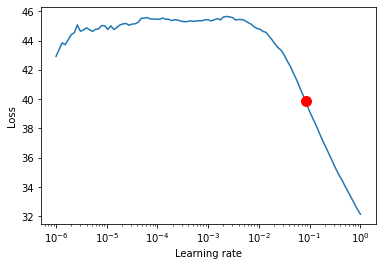

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Train model

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=12,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=10,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 18.4k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 671   
3  | prescalers                         | ModuleDict                      | 200   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 648   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 648   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 648 

Global seed set to 77


# Hyperparameter tuning

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

# Evaluate performance

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(6.9875)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

IndexError: ignored

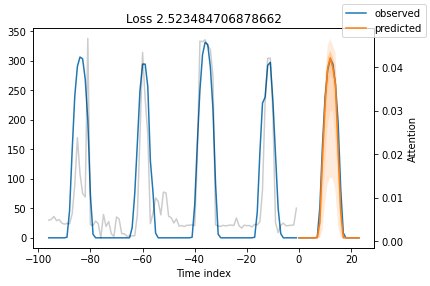

In [ ]:
for idx in range(4):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data['agency'].value_counts()

Agency_02    540
Agency_05    540
Agency_48    540
Agency_58    480
Agency_57    480
            ... 
Agency_36    180
Agency_35    180
Agency_33    180
Agency_34    180
Agency_37    120
Name: agency, Length: 58, dtype: int64